## Business Understanding
Understanding the relationship between salary and job satisfaction can be important not only from an employer point of view but as well as an employee. Salary is often considered as the number one factor for job satisfaction. Knowledge about that relationship can affect decisions if salary is a suitable measure to influence job satisfaction.

In this notebook, I will try to analyze how the salary of a developer has influence on job satisfaction.
The first question I will look into is, if there is a linear correlation between salary and job satisfaction.
With the second question, I will try to confirm a common known fact that says that salaries rise with more years of work (programing) experience. I will use this question as a bridge to my third question.
The third question will be about job satisfaction over years of programing. 

If salary is really the major driver of job satisfaction, there should be a similar increase in job satisfaction over the years as it is over salary. Assumed there is a positive trend towards higher salaries over years of programing experience (see question 2).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Understanding
We will be working on the Stack Overflow Developer Survey of 2017.
This Dataset consists of two files.
* survey_results_schema.csv, contains the questions that have been asked
* survey_results_public.csv, contains the actual answers per responded

In [3]:
#load schema into pandas
schema = pd.read_csv("./survey_results_schema.csv")
schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


From looking at all the questions, we can obtain that the following columns are of interest:
* JobSatisfaction
* EmploymentStatus
* Country
* Salary
* YearsCodedJob

Now we will look at the actual results.

In [4]:
#load results into pandas
df = pd.read_csv("./survey_results_public.csv")
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We first we have to make sure, if there are any missing values in the columns of interest.
We will print the percentage of completeness per column of our interest.

In [5]:
print("Professional: %f" % (df["Professional"].count()/df.shape[0]))
print("Country: %f" % (df["Country"].count()/df.shape[0]))
print("Salary: %f" % (df["Salary"].count()/df.shape[0]))
print("YearsCodedJob: %f" % (df["YearsCodedJob"].count()/df.shape[0]))
print("JobSatisfaction: %f" % (df["JobSatisfaction"].count()/df.shape[0]))
print("EmplymentStatus: %f" % (df["EmploymentStatus"].count()/df.shape[0]))

Professional: 1.000000
Country: 1.000000
Salary: 0.250837
YearsCodedJob: 0.795649
JobSatisfaction: 0.785648
EmplymentStatus: 1.000000


We now know that the following columns are incomplete and that we have to take care of that later.
* JobSatisfaction
* Salary
* YearsCodedJob

By looking at the possible answers of "EmploymentStatus", we will consider only full-time employed people for the evaluation later. That is also the largest group in that survey.

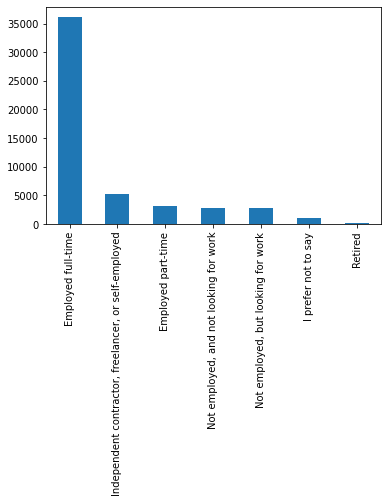

In [6]:
df["EmploymentStatus"].value_counts().plot(kind='bar')

"YearsCodedJob" has categorical values. For any regression analysis we have transform these later to integers.

In [7]:
df["YearsCodedJob"].unique()

array([nan, '20 or more years', '9 to 10 years', '10 to 11 years',
       '8 to 9 years', '7 to 8 years', '11 to 12 years', '15 to 16 years',
       '1 to 2 years', '3 to 4 years', '12 to 13 years',
       'Less than a year', '5 to 6 years', '16 to 17 years',
       '13 to 14 years', '6 to 7 years', '2 to 3 years', '17 to 18 years',
       '4 to 5 years', '14 to 15 years', '18 to 19 years',
       '19 to 20 years'], dtype=object)

We see that the mean salary per country is varies a lot. That makes it hard to make analysis by the absolut value.

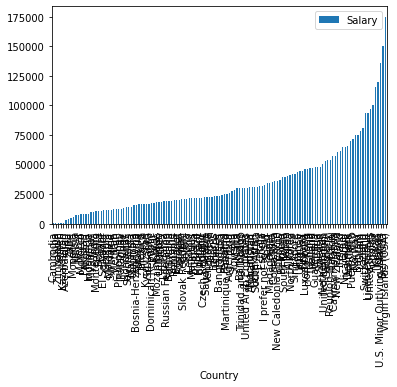

In [8]:
#show mean Salary by Country
pd.DataFrame(df.query("EmploymentStatus == 'Employed full-time'").groupby(['Country']).mean()['Salary']).dropna().sort_values(by=["Salary"]).plot(kind='bar')

Even if we would transform the salaries to a relative representation, there would still be a risk of country specific effects. Therefore, for simplicity we will only consider data from the US, as this group has the most answers.

In [9]:
#show answer count of Salary by Country and EmploymentStatus == 'Employed full-time
pd.DataFrame(df.query("EmploymentStatus == 'Employed full-time'").groupby(['Country']).count()["Salary"].sort_values())

,Salary
Country,
Tadjikistan,0
Iraq,0
Bouvet Island,0
Gibraltar,0
Brunei Darussalam,0
...,...
Canada,655
India,810
Germany,916


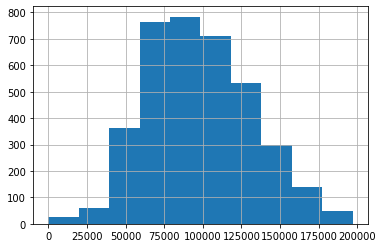

In [10]:
# show histogram of salaries from US and full-time employed people
pd.DataFrame(df.query("EmploymentStatus == 'Employed full-time' and Country == 'United States'"))["Salary"].dropna().hist()

By looking at JobSatisfaction, we see that the data is represented as integer values from 0 to 10. So no need to make any modification on them.

mean: 6.957078
std: 2.167652


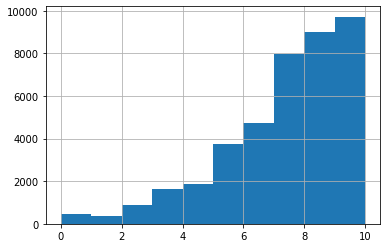

In [11]:
df["JobSatisfaction"].hist()
print("mean: %f" % df["JobSatisfaction"].mean())
print("std: %f" % df["JobSatisfaction"].std())

# Q1: What is the relationship between JobSatisfaction and Salary?
### Data Preparation and Data Modelling

As we previously defined, we will only look at data from full-time employed people from the US. We also know that there are many missing values in the Salary column. Therefore, we need to drop all JobStatisfaction data, which has missing Salary data.

In [12]:
# query data of interest and drop missing rows
q_s = df.query("EmploymentStatus == 'Employed full-time' and Country == 'United States'")
q_s = q_s[['Salary', 'JobSatisfaction']].dropna()

The relationship will be modelled and plotted via linear regression with the help of seabornd regplot() function.
For a better visualization on how the underlying data looks like, we will also plot the used data points as far as that makes sense. As the values of Salary are continuous and would cover up all the space on the plot, we will put them into equally sized bins (intervals). Then we can calculate the mean and the standard deviation of those bins and plot them together with the regression line.

In [22]:
# put data into bins
bins = np.linspace(0, 200000, 21) #create bin of size 10000 USD
group = q_s.groupby(pd.cut(q_s.Salary, bins)) # group data by bins

# calculate mean of bins with std_err
plot_centers = (bins [:-1] + bins [1:])/2
plot_val_mean = group.JobSatisfaction.mean()
plot_val_std = group.JobSatisfaction.std()

As we are going to use linear regression on the other questions as well. We will define a reusable plot function, which can plot the regression line, data points and error bars of our choice.

In [23]:
def my_regplot(data, x, y, xlim, ylim, err_cen, err_mean, err_std):
    plt.errorbar(err_cen, err_mean, err_std, linestyle='None', marker='o')
    
    sns.set_style("whitegrid")
    sns.set_context("paper")
    sns.set_style( {'xtick.bottom': True, 'ytick.left': True})
    ax = sns.regplot(x=x, y=y, marker=" ", order=1, data=data)
    ax.set(ylim=ylim)
    ax.set(xlim=xlim)

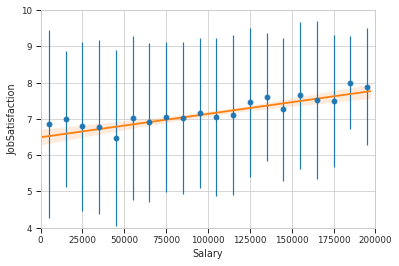

In [24]:
my_regplot(data=q_s, x="Salary", y="JobSatisfaction", 
           xlim=(0,200000), ylim=(4,10),
           err_cen = plot_centers,
           err_mean = plot_val_mean,
           err_std = plot_val_std)

### Evaluation
We can see that there is indeed a trend towards higher job satisfaction with higher salary. The big spread in standard deviation indicates that there is still a big uncertainty. However, we see that the lower bound gets higher over salary, supporting a real incline.
The values below 40k don’t seem much in line with the overall trend. Such salaries don't really fit into the full-time job category. They might disturb this regression analysis slightly, but by looking at the histogram some cells above, the numbers are low and we will leave them in place.

# Q2: What is the relationship between Salary and YearsProgramJob (Experience)?
### Data Preparation and Data Modelling
We will still work on the data of full-time employed people from the US.

In [25]:
q_yp2 = df.query("EmploymentStatus == 'Employed full-time' and Country == 'United States'")

#drop NaN on 'YearsProgram' and 'Salary'
q_yp2 = q_yp2[['YearsCodedJob', 'Salary']].dropna()

We know from the data understanding part that YearsProgramJob has categorical values and we need to map these categories into continues values.
We will do the following mapping.

In [26]:
mapping ={ "Less than a year": 1,
           "1 to 2 years": 2,
         "2 to 3 years": 3,
         "3 to 4 years": 4,
         "4 to 5 years": 5,
         "5 to 6 years": 6,
         "6 to 7 years": 7,
         "7 to 8 years": 8,
         "8 to 9 years": 9,
         "9 to 10 years": 10,
         "10 to 11 years": 11,
         "11 to 12 years": 12,
         "12 to 13 years": 13,
         "13 to 14 years": 14,
         "14 to 15 years": 15,
         "15 to 16 years": 16,
         "16 to 17 years": 17,
         "17 to 18 years": 18,
         "18 to 19 years": 19,
         "19 to 20 years": 20,
         "20 or more years": 21}

#map ints on categorical 'YearsProgram' vals
q_yp2 = q_yp2.replace({'YearsCodedJob': mapping})

Now we will do a linear regression modelling and plot the line together with the mean Salary values per Year and the error.

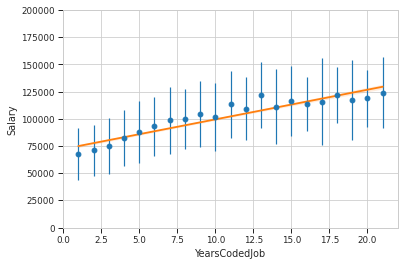

In [27]:
#group by YearsProgram
group = q_yp2.groupby(q_yp2.YearsCodedJob)

#plot mean of groups with std_err
plot_centers = list(range(1,22,1))
plot_val_mean = group.Salary.mean()
plot_val_std = group.Salary.std()

my_regplot(data=q_yp2, x="YearsCodedJob", y="Salary", 
           xlim=(0,22), ylim=(0,200000),
           err_cen = plot_centers,
           err_mean = plot_val_mean,
           err_std = plot_val_std)

### Evaluation
There is a clear undeniable trend towards more money with more years of programming experience. However based on the data points, the trend doesn't seem linear, it looks more logarithmic. However, that doesn't change the conclusion, that with more years of experience you will earn more money.

# Q3: What is the relationship between JobSatisfaction and YearsProgramJob (Experience?)
### Data Preparation and Data Modelling
We will still work on the data of full-time employed people from the US.

In [28]:
# query data of interest and drop missing rows
q_yp = df.query("EmploymentStatus == 'Employed full-time' and Country == 'United States'")
q_yp = q_yp[['YearsCodedJob', 'JobSatisfaction']].dropna()

We will do the same mapping as in Q2.

In [29]:
# map integers on categorical 'YearsProgramJob' vals
q_yp = q_yp.replace({'YearsCodedJob': mapping})

Now we will do a linear regression modelling and plot the line together with the mean JobStatisfaction valves per Year and the error.

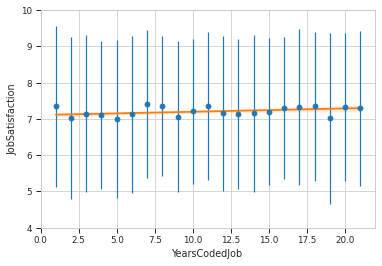

In [30]:
# group by YearsProgramJob (1,2,3,...)
group = q_yp.groupby(q_yp.YearsCodedJob)

# calc mean of years with std_err
plot_centers = list(range(1,22,1))
plot_val_mean= group.JobSatisfaction.mean()
plot_val_std = group.JobSatisfaction.std()

# calc regression and plot reg. line with datapoints
my_regplot(data=q_yp, x="YearsCodedJob", y="JobSatisfaction", 
           xlim=(0,22), ylim=(4,10),
           err_cen = plot_centers,
           err_mean = plot_val_mean,
           err_std = plot_val_std)

### Evaluation
There is hardly a rising trend to be seen , although there is still an increasing trend. That might indicate that there is indeed a correlation between rising salary and job satisfaction. However, it is really small. That might indicate that there are other major drivers that influence job satisfaction and have impact on salary. For example your educational background or company size.

## Discussion
So does salary increase job satisfaction? — This is not as clear as it seems, money is more the result and not the source of job satisfaction. The correlation in the first questions is entangled with influencing factors such as educational background or company size or type, that on their own have influence your actual job role as we can see on the values below.
This data shows, that factors such as the ability to work remote, the company type, size or the educational background have different effects on salary and job satisfaction that don't fit into the trend we saw in question 1.

In [31]:
tempdf = df.query("EmploymentStatus == 'Employed full-time' and Country == 'United States'")
#tempdf = tempdf[['Salary', 'JobSatisfaction']].dropna()
print(tempdf.groupby(['CompanySize'])[['JobSatisfaction', 'Salary']].mean().sort_values(by='JobSatisfaction'))
print("")
print(tempdf.groupby(['HomeRemote'])[['JobSatisfaction', 'Salary']].mean().sort_values(by='JobSatisfaction'))
print("")
print(tempdf.groupby(['CompanyType'])[['JobSatisfaction', 'Salary']].mean().sort_values(by='JobSatisfaction'))
print("")
print(tempdf.groupby(['FormalEducation'])[['JobSatisfaction', 'Salary']].mean().sort_values(by='JobSatisfaction'))
print("")

                          JobSatisfaction         Salary
CompanySize                                             
5,000 to 9,999 employees         6.887665  100662.703883
I don't know                     6.953216   79665.406780
1,000 to 4,999 employees         7.058485  100439.840708
10,000 or more employees         7.097484  107313.516775
500 to 999 employees             7.115772   97187.148289
100 to 499 employees             7.203252   97813.521320
20 to 99 employees               7.271597   91828.744856
10 to 19 employees               7.372093   86265.073529
Fewer than 10 employees          7.453564   81423.193286
I prefer not to answer           7.834862   99590.000000

                                                    JobSatisfaction  \
HomeRemote                                                            
It's complicated                                           6.926778   
Never                                                      6.970164   
About half the time            